## setup

In [2]:
# imports and environment setup
import numpy as np
import matplotlib.pyplot as plt
import random
# from torchinfo import summary
from tqdm import tqdm
from copy import deepcopy
from IPython.display import clear_output

import torch, timm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import v2

import pandas as pd

_ = torch.set_grad_enabled(False)

In [2]:
# common variables: device
device = torch.device(
    "mps" if torch.backends.mps.is_available() else (
    "cuda" if torch.cuda.is_available() else
    "cpu"
))
seed = 42

In [3]:
# utility functions
def cmp_arrays(a, b):
    if torch._is_all_true(a == b):
        print('IDENTICAL')
        return True
    else:
        for ats, at in zip(['1e-8', '1e-6', '1e-4'],[1e-8, 1e-6, 1e-4]): 
            if torch.allclose(a, b, atol=at):
                print(f'CLOSE ENOUGH (atol < {ats})')
                return True
        print(f'abs distance: {torch.dist(a, b, p=1).item()}')
        return False
    
def test_correctness(A, B, compare_fn, args=[], kwargs={}):
        a = A(*args, **kwargs)
        b = B(*args, **kwargs)
        compare_fn(a, b)

def test_speed(A, B, n, args=[], kwargs={}):
    for _ in tqdm(range(n[0])):
        A(*args, **kwargs)
    for _ in tqdm(range(n[1])):
        B(*args, **kwargs)

def get_random_sample(dataset):
    i = np.random.randint(len(dataset))
    return dataset[i][0].to(device).unsqueeze(0)

def count_classes(ds, indices):
    targets = ds.dataset.targets
    classes = torch.tensor(targets)[indices]
    counts = torch.zeros((100,))
    for i in range(100):
        counts[i] = (classes == i).sum()
    return counts

def get_balanced_indices(labels, subset_size):
    """
        labels: list of labels of data samples
        subset_size: factor by which to reduce dataset
    """
    labels = torch.tensor(labels, dtype=torch.int32)
    num_classes = torch.unique(labels).numel()

    indices = [torch.nonzero(labels==i).flatten() for i in range(num_classes)]

    numel = int(labels.numel() * subset_size)
    per_class = torch.full((num_classes,), int(numel / num_classes), dtype=torch.int32)
    remainder = int(numel - int(numel / num_classes)*num_classes)
    per_class[:remainder] += 1

    per_class_indices = []
    for i in range(num_classes):
        p = torch.randperm(indices[i].numel())
        per_class_indices.append(indices[i][p[:per_class[i]]])

    p = torch.randperm(numel)
    balanced = list(per_class_indices[0])
    for i in range(1, num_classes):
        balanced = balanced + list(per_class_indices[i])
    balanced = torch.tensor(balanced, dtype=torch.int32)[p]
    return list(balanced)

@torch.no_grad()
def test_model(model, dataloader):
    sm = torch.nn.Softmax(dim=1)
    acc, correct = 0, 0
    for features, labels in tqdm(iter(dataloader)):
        features = features.to(device)
        labels = labels.to(device)
        clf = sm(model(features)).argmax(1)
        correct += (clf == labels).sum()
    acc = correct / len(dataloader.dataset)
    return acc

In [4]:
# load_model_timm, load_dataset
def load_model_timm(model_type, dataset_name, verbose=False, top10_idx=-1):
    """ 
    model   types: B/16, S/16 or Ti/16
    dataset names: cifar100 or oxford-iiit-pet
    top10_idx    : int [1, 10]
    """
    import pandas as pd
    index = pd.read_csv('models/index.csv')
    pretrains = set(
        index.query('ds=="i21k"').groupby('name').apply(
        lambda df: df.sort_values('final_val').iloc[-1], 
        include_groups=False).filename
    )
    finetunes = index.loc[index.filename.apply(lambda name: name in pretrains)]
    checkpoint = (
        finetunes.query(f'name=="{model_type}" and adapt_ds=="{dataset_name}"')
        .sort_values('adapt_final_val').iloc[-10].adapt_filename
    ) # Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224
    if verbose: print(f"Loaded checkpoint: {checkpoint}")
    
    timm_modelnames = {
        'Ti/16-224': 'vit_tiny_patch16_224',
        'Ti/16-384': 'vit_tiny_patch16_384',
        'S/16-224': 'vit_small_patch16_224',
        'S/16-384': 'vit_small_patch16_384',
        'B/16-224': 'vit_base_patch16_224',
        'B/16-384': 'vit_base_patch16_384'
    }
    num_classes = 100 if dataset_name == 'cifar100' else 37
    res = int(checkpoint.split('_')[-1])
    model = timm.create_model(timm_modelnames[f'{model_type}-{res}'], num_classes=num_classes)
    
    # downloading a checkpoint automatically
    # may show an error, but still downloads the checkpoint
    from tensorflow.io import gfile # type: ignore
    if not gfile.exists(f'models/{checkpoint}.npz'):     
        gfile.copy(f'gs://vit_models/augreg/{checkpoint}.npz', f'models/{checkpoint}.npz')
    timm.models.load_checkpoint(model, f'models/{checkpoint}.npz')

    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
    return model



def load_dataset(dataset_name, batch_size, model_cfg=None, subset_size = 1., res = (224, 224), train=False, download_dataset=False, do_balanced_subset=False):
    """
    dataset name: cifar100 or oxford-iiit-pet
    """
    dataset = (
        datasets.CIFAR100('data/', train=train, download=download_dataset) if dataset_name == 'cifar100' 
        else datasets.OxfordIIITPet('data/', split=('trainval' if train else 'test'))
    ) 
    if model_cfg is None:
        m, s = [0.5]*3, [0.5]*3
    else:
        m, s = model_cfg['mean'], model_cfg['std']
        res = model_cfg['input_size'][-2:]
    dataset.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=m, std=s),
            v2.Resize(res),
    ])
    g = torch.Generator()
    g.manual_seed(seed)
    if subset_size < 1.0:
        n = len(dataset)
        n_small = int(subset_size * n)
        dataset, _ = random_split(dataset, [n_small, n - n_small], generator=g)
        if do_balanced_subset:
            balanced_indices = get_balanced_indices(dataset.dataset.targets, subset_size)
            dataset.indices = balanced_indices
    g = torch.Generator()
    g.manual_seed(seed)
    dataloader = DataLoader(dataset, batch_size=batch_size, generator=g)
    return dataset, dataloader

## work-in-progress code

In [5]:
# importance scoring functions
def svd_score_reference(q, k):
    """q, k shape (batch, head, sequence, dimension)"""
    U, S, Vt = torch.linalg.svd((q @ k.mT).cpu().double())
    U, S, Vt = U.to(ref := q), S.to(ref), Vt.to(ref)
    
    U  =  U.unsqueeze(2).transpose(2, -1)
    Vt = Vt.unsqueeze(2).transpose(2, -2)
    S  =  S[..., None, None]
    svd_maps = ((U * S) @ Vt).flatten(start_dim=-2)

    q = q.unsqueeze(2).transpose(2, -1)
    k = k.unsqueeze(2).permute(0, 1, 4, 2, 3)
    att_maps = (q @ k).flatten(start_dim=-2)

    F.normalize(att_maps, dim=-1, out=att_maps)
    F.normalize(svd_maps, dim=-1, out=svd_maps)
    scores = torch.einsum('bhdm,bhnm->bhdn', att_maps, svd_maps)
    torch.abs(scores, out=scores)
    return scores.sum(-1)

def svd_score(q, k):
    """q, k shape (batch, head, sequence, dimension)"""
    _, RQ = torch.linalg.qr(q.cpu(), mode='r')
    _, RK = torch.linalg.qr(k.cpu(), mode='r')
    Ug, S, Vhg = torch.linalg.svd(RQ @ RK.mT, full_matrices=False)
    RQ, RK = RQ.to(ref := q), RK.to(ref)
    Uhg, Vhg = Ug.mT.to(ref), Vhg.to(ref)    

    F.normalize(RQ, dim=2, out=RQ)
    F.normalize(RK, dim=2, out=RK)
    A, B = Uhg @ RQ, Vhg @ RK
    torch.multiply(A, B, out=A)
    torch.abs(A, out=A)
    return A.sum(-2)


def similarity_score_reference(x):
    B, _, D = x.shape
    score = torch.ones((B, D)) * D
    F.normalize(x, dim=1, out=x)
    for (d1, d2) in np.ndindex(D, D):
        score[:, d1] -= abs((x[:, :, d1] * x[:, :, d2]).sum(dim=1))
    return score

def similarity_score(x):
    """input shape (B, N, D) - batch, sequence len, embedding dimension"""
    x = F.normalize(x, dim=1)
    score = torch.einsum('bnd,bnt->bdt', x, x)
    torch.abs(score, out=score)
    score = x.shape[-1] - score.sum(dim=-1) 
    return score

In [57]:
a1 = torch.randn((1, 2, 4))
print(a1.numpy())
# print(torch.outer(a1[0,0], a1[0,0]))
sc = similarity_score(a1).squeeze()
print(sc.numpy())

[[[-1.2 -0.1 -1.5  0.6]
  [-0.4 -0.2  0.   1.5]]]
[0.7 0.8 1.2 1. ]


In [6]:
# attention block with split qk & v matrices, convert_attention_blocks
class Attention(nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.fused_attn = attn.fused_attn
        
        self.num_heads = attn.num_heads
        self.scale = attn.scale
        # qkv.weight.shape: (num_heads * (2*qk_dim + v_dim), emb_dim)
        self.qkv = attn.qkv
        self.q_norm = attn.q_norm
        self.k_norm = attn.k_norm
        self.attn_drop = attn.attn_drop
        self.proj = attn.proj
        self.proj_drop = attn.proj_drop
        
        # previous attention class assumed 
        # that all head dims for Q, K, V are the same
        # between heads and between Q, K, V
        # this attention class doesn't assume
        # that head dims are the same between Q, K, V
        # but, still, they're the same between heads of Q, K, V
        self.qk_dim, self.v_dim = attn.head_dim, attn.head_dim
        self.split_dim = [self.num_heads*c for c in [self.qk_dim]*2+[self.v_dim]]


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, _ = x.shape
        q, k, v = torch.split(self.qkv(x), self.split_dim, dim=-1)
        q = q.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        k = k.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        v = v.reshape(B, N, self.num_heads, self.v_dim).transpose(1, 2)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, self.split_dim[-1])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

def convert_attention_blocks(model):
    for i, b in enumerate(model.blocks):
        model.blocks[i].attn = Attention(b.attn)
    return model

In [7]:
# hooks and hooks management
class SNP:
    def __init__(self, attn, do_svd_scoring=True, do_sim_scoring=True):
        self.num_heads = attn.num_heads
        self.qk_dim = attn.qk_dim
        self.v_dim = attn.v_dim
        self.split_dim = attn.split_dim
        self.scale = attn.scale
        self.do_svd_scoring = do_svd_scoring
        self.do_sim_scoring = do_sim_scoring
        self.svd_scores = 0
        self.sim_scores = 0

    def __call__(self, module, inp, out):
        B, N = out.shape[:2]
        q, k, v = torch.split(out, self.split_dim, dim=-1)
        q = q.view(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        k = k.view(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        if self.do_svd_scoring:
            self.svd_scores = svd_score(q, k)
        if self.do_sim_scoring:
            self.sim_scores = similarity_score(v).view(B, self.num_heads, self.v_dim)

class MLP_SNP:
    def __init__(self, module, do_scoring=True):
        self.out_features = module.out_features
        self.do_scoring = do_scoring
        self.sim_scores = 0
        
    def __call__(self, module, inp, out):
        if self.do_scoring:
            self.sim_scores = similarity_score(out)

def register_hooks(model, scoring_flags):
    """
        scoring_flags: (SVD [QK], cos-sim [V], cos-sim [MLP])
    """
    for b in model.blocks:
        snp = SNP(b.attn, *scoring_flags[:2])
        b.attn.qkv.register_forward_hook(snp)
        mlp = MLP_SNP(b.mlp.fc1, scoring_flags[2])
        b.mlp.fc1.register_forward_hook(mlp)
    return model

def remove_hooks(model):
    for b in model.blocks:
        b.attn.qkv._forward_hooks.popitem()
        b.mlp.fc1._forward_hooks.popitem()
    return model

In [8]:
# collect_scores, zero_out (weights)
def collect_scores(model, dl):
    svd_scores, sim_scores, mlp_scores = [], [], []
    snp_hooks, mlp_hooks = [], []
    for b in model.blocks:
        snp_hooks.append(next(iter(b.attn.qkv._forward_hooks.values())))
        mlp_hooks.append(next(iter(b.mlp.fc1._forward_hooks.values())))
        hook = snp_hooks[-1]
        svd_scores.append(torch.zeros((hook.num_heads, hook.qk_dim), device=device))
        sim_scores.append(torch.zeros((hook.num_heads, hook.v_dim), device=device))
        mlp_scores.append(torch.zeros((mlp_hooks[-1].out_features,), device=device))
    
    with torch.no_grad():
        for features, _ in tqdm(dl):
            model(features.to(device))
            for i, (h1, h2) in enumerate(zip(snp_hooks, mlp_hooks)):
                if h1.do_svd_scoring: svd_scores[i] += h1.svd_scores.sum(0)
                if h1.do_sim_scoring: sim_scores[i] += h1.sim_scores.sum(0)
                if h2.do_scoring: mlp_scores[i] += h2.sim_scores.sum(0)

    return svd_scores, sim_scores, mlp_scores

def zero_out(model, sparsity, svd_scores, sim_scores, mlp_scores):
    svd_list, sim_list, mlp_list = [], [], []
    for svd, sim, mlp in zip(svd_scores, sim_scores, mlp_scores):
        svd_list.append(svd.sort().indices)
        sim_list.append(sim.sort().indices)
        mlp_list.append(mlp.sort().indices)

    for b, svd, sim, mlp in zip(model.blocks, svd_list, sim_list, mlp_list):
        m = b.attn
        o = m.qk_dim*m.num_heads
        ta, tb = int(m.qk_dim*sparsity[0]), int(m.v_dim*sparsity[1])
        for h in range(m.num_heads):
            ho, hvo = h * m.qk_dim, h * m.v_dim
            
            m.qkv.weight[svd[h, :ta]+ho] = 0
            m.qkv.weight[svd[h, :ta]+ho+o] = 0
            m.qkv.bias[svd[h, :ta]+ho] = 0
            m.qkv.bias[svd[h, :ta]+ho+o] = 0

            m.qkv.weight[sim[h, :tb]+2*o+hvo] = 0
            m.qkv.bias[sim[h, :tb]+hvo] = 0
            m.proj.weight[:, sim[h, :tb]+hvo] = 0

        
        tc = int(b.mlp.fc1.out_features*sparsity[2])
        b.mlp.fc1.weight[mlp[:tc]] = 0
        b.mlp.fc2.weight[:, mlp[:tc]] = 0
    
    return model

In [9]:
# pruning testing function
def full_collect_scores(scoring, modelname, prunelen):
    dl = load_dataset('cifar100', 4, subset_size=prunelen)[1]
    model = convert_attention_blocks(load_model_timm(modelname, 'cifar100'))
    register_hooks(model, scoring)
    iscores = collect_scores(model, dl)
    remove_hooks(model)

    return iscores

def test_pruning(scoring, testing, modelname, testlen, prunelen, sparsity_levels, top10_idx=-1):
    """
        scoring: boolean flags (SVD [QK], cos-sim [V], cos-sim [MLP])
        testing: boolean flags (Att ,QK, V, MLP, All)
        model_type   : ('B/16', 'S/16', 'Ti/16')
        testlen, prunelen: float in [0, 1], size of dataset
        sparsity_levels: list. which sparsity values to test
    """
    # collecting importance scores
    iscores = full_collect_scores(scoring, modelname, prunelen)
    model = convert_attention_blocks(load_model_timm(modelname, 'cifar100'))

    # variables
    colors = ('tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:brown')
    testing_flagnames = ('Att', 'SVD', 'Sim', 'MLP', 'All')
    sparsity_levels = np.concatenate(([0], sparsity_levels))
    n_steps = len(sparsity_levels)
    dl  = load_dataset('cifar100', 8, subset_size=testlen)[1]
    results = np.full((5, n_steps), float(test_model(model, dl))*100)
    sl, z, old_opts = sparsity_levels, [0]*n_steps, np.get_printoptions()
    sparsities = [list(zip(*t)) for t in ((sl,sl,z), (sl,z,z), (z,sl,z), (z,z,sl), (sl,sl,sl))]

    # evaluating performance after pruning
    np.set_printoptions(precision=1, suppress=True, linewidth=100)
    for stage in np.flatnonzero(testing):
        for step in range(1, n_steps):
            zero_out((m := deepcopy(model)), sparsities[stage][step], *iscores)
            results[stage, step] = float(test_model(m, dl)) * 100

            clear_output(); print(f'Sparsity: {sparsity_levels*100}')
            for k, (f, n, r) in enumerate(zip(testing, testing_flagnames, results)):
                limit = n_steps if stage>k else step+1
                if f and stage>=k: print(f'{n}: {r[:limit]}')
    np.set_printoptions(**old_opts)

    # plotting results
    for stage in np.flatnonzero(testing):
        plt.plot(sl, results[stage], color=colors[stage], label=testing_flagnames[stage])
    plt.legend(); plt.show()

    return iscores

## test runs & experiments

Sparsity: [ 0. 10. 30. 50. 70. 90.]
SVD: [85.3 76.5 48.2 35.  16.5  4. ]


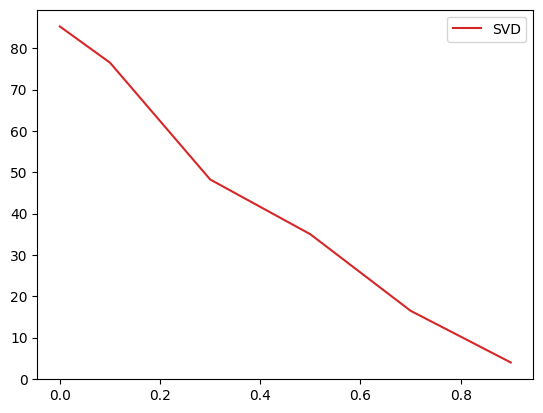

In [64]:
# pruning testing setup
"""
Expect from paper:
SVD: [72.2, 71, 67.5, 58.5, 39, 12]
Sim: [72.2, 68, 54  , 28  , 5 , .5]

Expect:
SVD: [86.8 85.4 81.1 70.3 46.9 14.4]
Sim: [86.8 81.8 64.9 33.7  6.    .6]

Random:
SVD: [86.8 81.  57.7 15.5  1.8]
Sim: [86.8 77.7 12.7  4.5  1.5]
MLP: [86.8 53.   5.8  1.8  1.3]


my {1}:  [85.3 76.5 48.2 35.  16.5]
my {16}: [85.3 76.2 47.  34.3 15. ]
rng   :  [85.3 82.7 59.2 21.3  5. ]

[85.3 26.   2.7  0.5  1.5  1.5]
"""
iscores = test_pruning(
    [True, False, False], 
    [False, True, False, False, False], 
    'Ti/16', .04, .01,
    np.linspace(0, .8, 5)+.1
)

In [ ]:
# accuracy test of timm model on subset of cifar100

# print(test_model(
#     convert_attention_blocks(load_model_timm('Ti/16', 'cifar100')),
#     load_dataset('cifar100', 8, subset_size=.25)[1]
# ))

In [ ]:
# test correctness and speed of svd importance scoring algorithm

# test_correctness(
#     svd_score_reference, svd_score, cmp_arrays,
#     (torch.randn(4, 3, 197, 64, device=device), torch.randn(4, 3, 197, 64, device=device))
# )

# test_speed(
#     svd_score_reference, svd_score, [50, 500], 
#     (torch.randn(4, 3, 197, 64, device=device), torch.randn(4, 3, 197, 64, device=device))
# )

In [ ]:
# test correctness and speed of column similarity importance scoring

# test_correctness(similarity_score_reference, similarity_score, cmp_arrays, [torch.randn((16,16,16))])

# test_speed(similarity_score_reference, similarity_score, [4, 8000], args=[torch.randn(((4, 256, 256)))])